In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data science case: Insurance company

---

An insurance company wants to identify customers willing to buy a new product. They gathered data
about customers to whom they offered the new product. You get information about whether they did or
did not sign up for the new product, together with some customer information and information about
their buying behavior of two other products.



## Dataset description

---


| Variable | Description | 
| :---------- | :------------- |
| ID | Unique customer identifier |
| Target|  Indicator of buying the new product (0 = no, 1=yes) |
| Loyalty|  Loyalty level, from low to high (0 to 3), 99 =unclassified |
| Age | Age in years |
| City|  Unique code per city |
| Age_p|  Age of partner in years |
| LOR|  Length of relationship in years |
| LOR_m|  Length of relationship in months |
| Prod_A|  Bought product A (0= no, 1=yes) |
| Type_A|  Type of product A |
| Turnover_A|  Amount of money spent on product A |
| Prod_B|  Bought product B (0= no, 1=yes) |
| Type_B|  Type of product B |
| Turnover_B|  Amount of money spent on product B |
| Contract|  Type of contract |



## Objectives

---

The analysis will try to answer the following:
- Which steps taken in this analysis?
- Which statistical modelling techniques were used and why?
- What are the results?
- Give a profile description of the customers who are likely to (not) buy the new product.
- Which customers should we target to do a marketing campaign for the new product?
- How accurate is the prediction of buying the new product?


## Content

---

* Import of the necessary packages
* Data import
* Exploratory Data Analysis
  * Age distribution
  * New product versus A and B
  * Age distribution by type of products (from A and B)
  * Cities
  * Turnover
  * Loyalty
* Machine Learning Models
  * Overview
  * Data preparation
  * Correlation matrix (heatmap)
  * Splitting training and test data
  * Random Forest
  * Other models (using Pipeline)
  * Neural network (using Keras)

## Import of the necessary packages

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, PolynomialFeatures, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Data import

In [4]:
import pandas as pd
data = pd.read_csv('insurance.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 15 columns):
TARGET        14016 non-null object
loyalty       14016 non-null int64
ID            14016 non-null int64
age           14016 non-null int64
city          14016 non-null int64
LOR           14016 non-null int64
prod_A        14016 non-null int64
type_A        14016 non-null int64
type_B        14016 non-null int64
prod_B        14016 non-null int64
turnover_A    14016 non-null float64
turnover_B    14016 non-null float64
contract      14016 non-null int64
age_P         14016 non-null int64
lor_M         14016 non-null int64
dtypes: float64(2), int64(12), object(1)
memory usage: 1.6+ MB


No missing data.  We can also confirm this with the following command.

In [6]:
data.isnull().sum()

TARGET        0
loyalty       0
ID            0
age           0
city          0
LOR           0
prod_A        0
type_A        0
type_B        0
prod_B        0
turnover_A    0
turnover_B    0
contract      0
age_P         0
lor_M         0
dtype: int64

In [7]:
data.head()

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


The columns type_A, type_B, loyalty, city and contract are assumed categorical.  Let's convert their type.

In [8]:
data.type_A = data.type_A.astype('category')
data.type_B = data.type_B.astype('category')
data.loyalty = data.loyalty.astype('category')
data.city = data.city.astype('category')
data.contract = data.contract.astype('category')

We verify:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 15 columns):
TARGET        14016 non-null object
loyalty       14016 non-null category
ID            14016 non-null int64
age           14016 non-null int64
city          14016 non-null category
LOR           14016 non-null int64
prod_A        14016 non-null int64
type_A        14016 non-null category
type_B        14016 non-null category
prod_B        14016 non-null int64
turnover_A    14016 non-null float64
turnover_B    14016 non-null float64
contract      14016 non-null category
age_P         14016 non-null int64
lor_M         14016 non-null int64
dtypes: category(5), float64(2), int64(7), object(1)
memory usage: 1.1+ MB


In [10]:
data.TARGET.value_counts()

N    8000
Y    6016
Name: TARGET, dtype: int64

We see the data is slightly unbalanced. For futher analysis, we replace Y/N by 1/0.

In [11]:
data.TARGET = data.TARGET.map(dict(Y=1, N=0))

# We verify
data.TARGET.value_counts()

0    8000
1    6016
Name: TARGET, dtype: int64

## Exploratory Data Analysis
Let's analyse the profile of the customer subscribing to the new product (TARGET=1) or not (TARGET=0).

### Age distribution
Let's start with their age distribution.

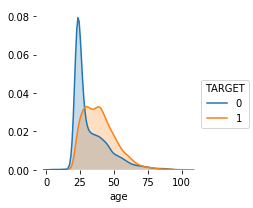

In [12]:
g = sns.FacetGrid(data, hue='TARGET')
g.map(sns.kdeplot, 'age', shade=True).add_legend()
sns.despine(left=True, bottom=True)

For illustration purposes, we here use distplot.

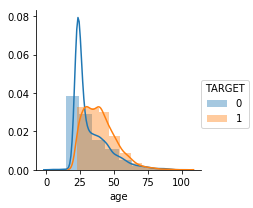

In [13]:
g = sns.FacetGrid(data, hue='TARGET')
g.map(sns.distplot,'age', bins=10).add_legend()

Customers that bought the new product seems to be older on average than the ones that didn't subscribe.  Let's retrieve the descriptive statistics:

In [14]:
data.loc[data.TARGET == 1].age.describe()

count    6016.000000
mean       39.680519
std        12.019518
min        23.000000
25%        30.000000
50%        38.000000
75%        47.000000
max       102.000000
Name: age, dtype: float64

We confirm that the mean of the age is 39 years.  It can be more convenient to visualise these numbers using Box and Whisker plots:

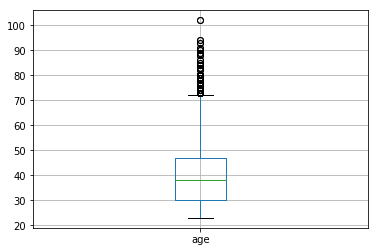

In [15]:
import matplotlib.pyplot as plt
data.loc[data.TARGET == 1].boxplot('age')

For customers that have NOT subscribed to the new product, we obtain the following :

In [16]:
data.loc[data.TARGET == 0].age.describe()

count    8000.000000
mean       33.027125
std        12.934848
min         5.000000
25%        23.000000
50%        27.000000
75%        40.000000
max       102.000000
Name: age, dtype: float64

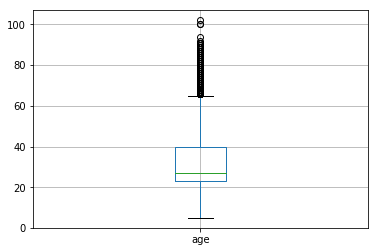

In [17]:
data.loc[data.TARGET == 0].boxplot('age')

On average, customers that are buying the new product are 39, while the others are 33. 

### Subscription to products A and B increases new product adoption?
We consider the customers opting for the new product and analyse whether they have also subscribed to product A and B (and if so, we identify the type of product they chose).  

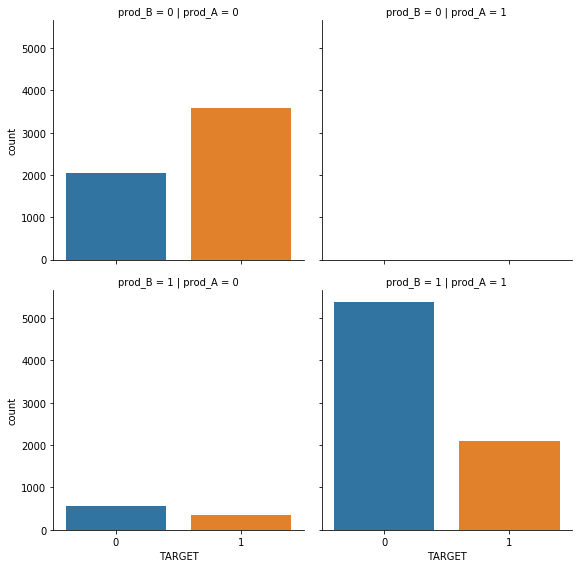

In [18]:
sns.factorplot(x='TARGET', col='prod_A', row='prod_B', kind='count', data=data)

- Top-left: Most customers buying the new product didn't subscribe to product A nor B (makes sense).
- Bottom-right: Similarly, most customers that didn't buy the new product already subscribed to product A and B
- Top-right: Lack of data about customers only subscribing to product A.
- Bottom-left: Detaining only product B does not seem to have an impact on the choice of subscribing to the new product

Let's analyse whether the type of product A (and B) has an impact.

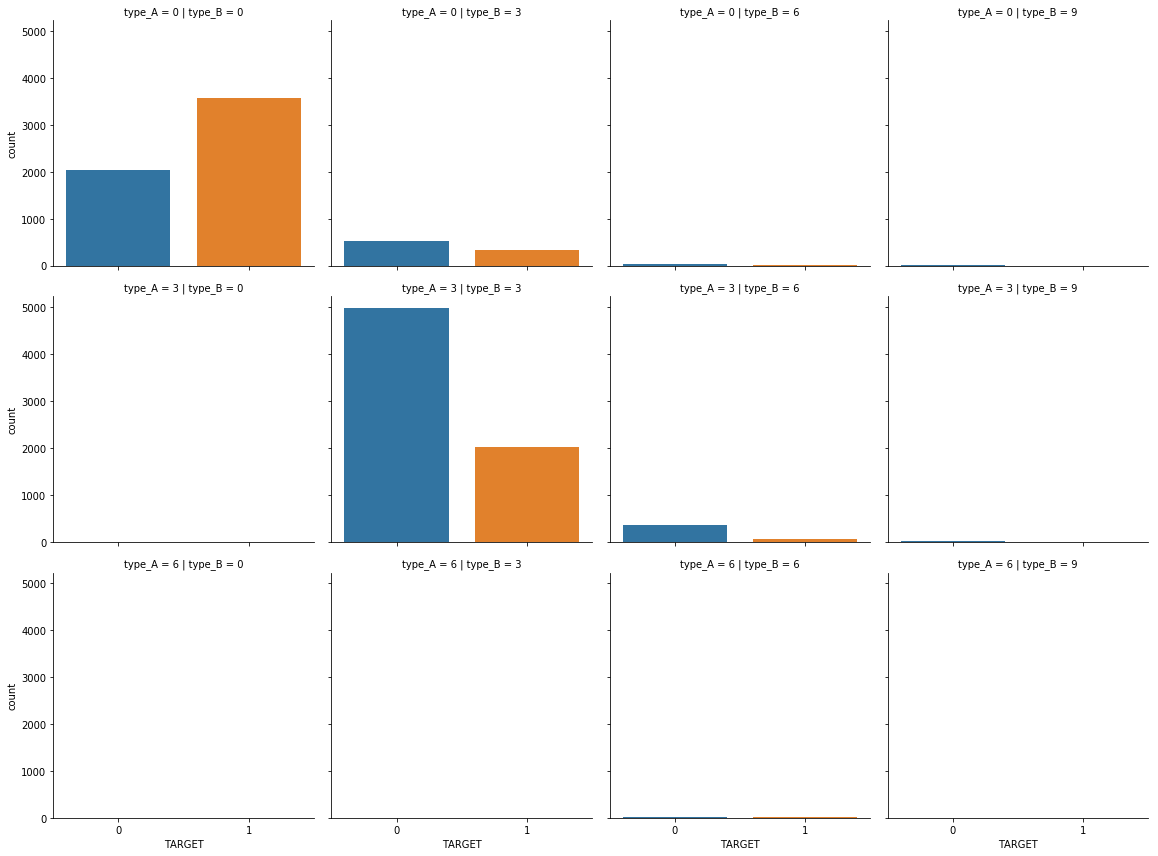

In [19]:
sns.factorplot(x='TARGET', col='type_B', row='type_A', kind='count', data=data)

We confirm the same results as before: customers without product A nor B are more inclined to subscribe to the new product.  In the dataset, the customers buying product A (type 3) and product B (type 3) are the most frequent, and for those, we observe that a high number of them didn't subscribe to the new product. Lack of data to confirm that the specific choice of type 3 for both A and B is causing this behaviour. 

We can reach the same conclusion as follows:

In [20]:
data.loc[(data.TARGET == 1)].groupby(['type_A','type_B'])['TARGET'].count()

type_A  type_B
0       0         3572
        3          338
        6            8
3       3         2020
        6           62
        9            2
6       6           12
        9            2
Name: TARGET, dtype: int64

From the customer opting for the new product (TARGET = 1):
- 3572 did not subscribe to A nor B
- 2020 subscribed to A (type 3) and B (type 3) simultanously.

Independently of their subscription to the new product, we obtain:

In [21]:
data.groupby(['type_A','type_B'])['TARGET'].count()

type_A  type_B
0       0         5614
        3          873
        6           42
        9            5
3       3         7001
        6          423
        9           28
6       6           28
        9            2
Name: TARGET, dtype: int64

From these numbers, we see that:
- From the 5614 customers that didn't subscribe to product A nor B, 3572 (63%) subscribed to the new product.  These customers should be targetted.
- From the 7001 customers that subscribed to product A (type 3) and product B (type 3) simultanously, only 2020 (30%) subscribed to the new product.

For convenience, one can display this information on a crosstab:

In [22]:
pd.crosstab([data.type_A,data.type_B],data.TARGET,margins=True).style.background_gradient(cmap='RdYlGn')

### Age distribution by type of product
We can look at the age distribution depending on the type of product (from A and/or B) chosen by the customers.

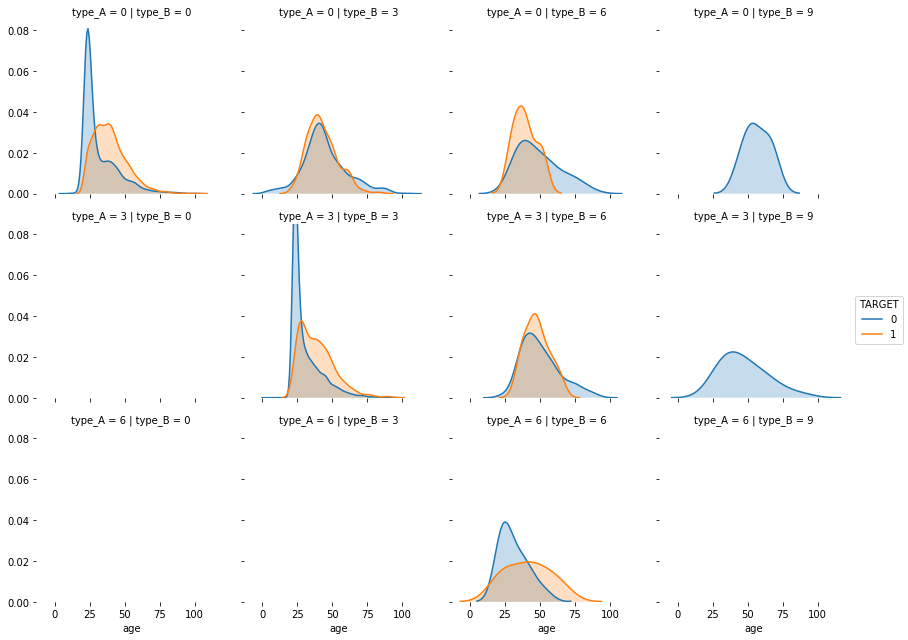

In [23]:
g = sns.FacetGrid(data, col='type_B', row='type_A', hue='TARGET')
g.map(sns.kdeplot, 'age', shade=True).add_legend()
sns.despine(left=True, bottom=True)

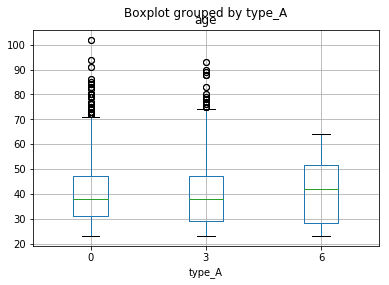

In [24]:
data.loc[data.TARGET == 1].boxplot('age', 'type_A')

In [25]:
data.loc[data.TARGET == 1].age.describe()

count    6016.000000
mean       39.680519
std        12.019518
min        23.000000
25%        30.000000
50%        38.000000
75%        47.000000
max       102.000000
Name: age, dtype: float64

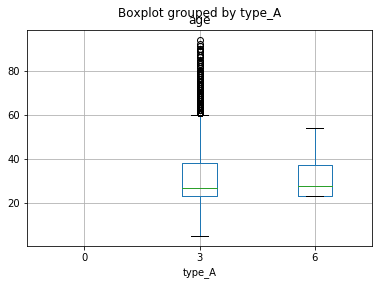

In [26]:
data.loc[(data.prod_A == 1) & (data.TARGET == 0)].boxplot('age', 'type_A')

In [27]:
data.loc[(data.prod_A == 1) & (data.TARGET == 0)].age.describe()

count    5384.000000
mean       32.135587
std        12.063882
min         5.000000
25%        23.000000
50%        27.000000
75%        38.000000
max        94.000000
Name: age, dtype: float64

### City

We filter the dataset so as to retrieve records with a city appearing more than 10 times.

In [28]:
cities = data.city.value_counts()
data2 = data[data.city.isin(cities[cities>10].index)]

# Just to check
data2.city.value_counts().head(10)

2     13720
1        28
0        26
8        21
9        20
4        19
7        15
5        15
14       13
3        12
Name: city, dtype: int64

In [29]:
data2.loc[data.TARGET == 1].city.value_counts().head(10)

2     5902
1       22
0       12
8        8
7        8
9        8
4        8
14       6
6        4
5        4
Name: city, dtype: int64

We see that:
- In city 2, 5902 customers out of 13720 (43%) opted for the new product 
- In city 1, 22 customers out of 28 (78%) opted for the new product

Such information can help targetting to specific cities.

The same information can be retrieved using a crosstab.

In [30]:
pd.crosstab(data.city,data.TARGET,margins=True).head(10).style.background_gradient(cmap='RdYlGn')

TARGET,0,1,All
city,,,
-999999,6,4,10
0,14,12,26
1,6,22,28
2,7818,5902,13720
3,8,4,12
4,11,8,19
5,11,4,15
6,7,4,11
7,7,8,15


### Turnover 

In [31]:
data.turnover_A.describe()

count    14016.000000
mean       379.161320
std         92.612207
min        300.095909
25%        334.919412
50%        367.891493
75%        399.744923
max       5568.784139
Name: turnover_A, dtype: float64

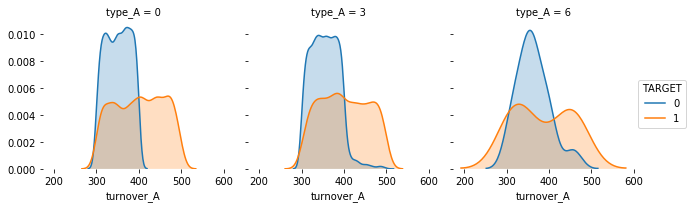

In [32]:
g = sns.FacetGrid(data.loc[(data.turnover_A < 500)&(data.turnover_B < 500)], col='type_A', hue='TARGET')
g.map(sns.kdeplot, 'turnover_A', shade=True).add_legend()
sns.despine(left=True, bottom=True)

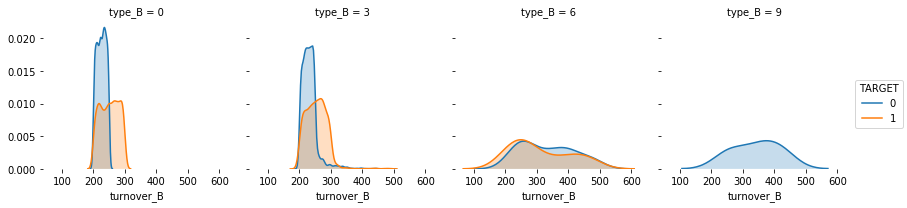

In [33]:
g = sns.FacetGrid(data.loc[(data.turnover_A < 500)&(data.turnover_B < 500)], col='type_B', hue='TARGET')
g.map(sns.kdeplot, 'turnover_B', shade=True).add_legend()
sns.despine(left=True, bottom=True)

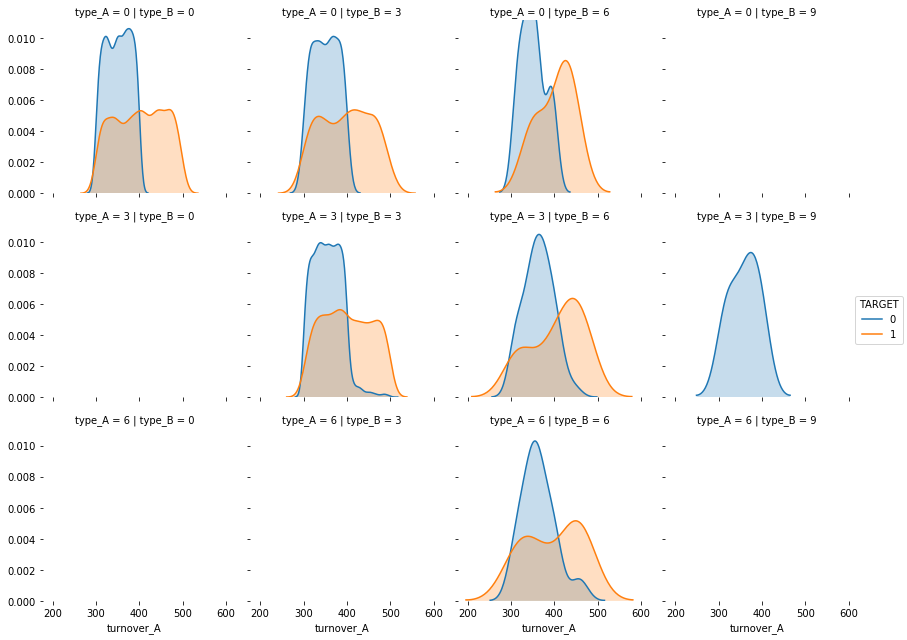

In [34]:
g = sns.FacetGrid(data.loc[(data.turnover_A < 500)&(data.turnover_B < 500)], col='type_B', row='type_A', hue='TARGET')
g.map(sns.kdeplot, 'turnover_A', shade=True).add_legend()
sns.despine(left=True, bottom=True)

### Loyalty

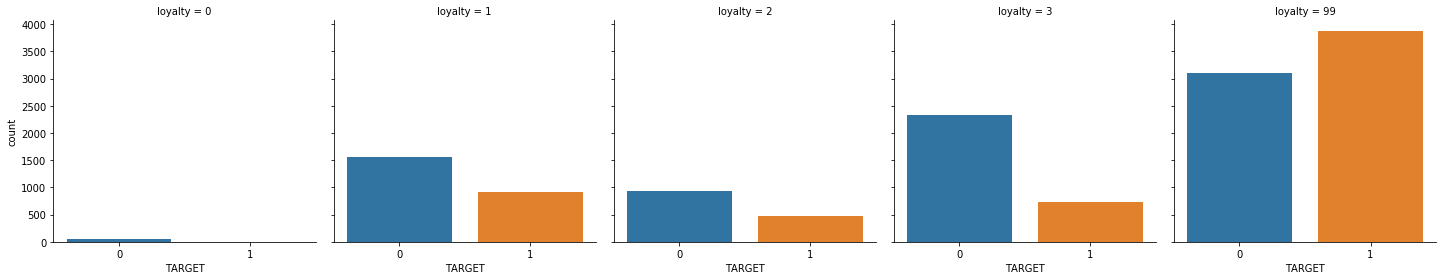

In [35]:
sns.factorplot(x='TARGET', col='loyalty', kind='count', data=data)

Disregarding the unclassified customers (loyalty = 99), customers with a high loyalty (3) don't seem to be inclined to buy the new product.  They shouldn't be targetted in priority. For customers with loyalty 1, the gap seems the smallest.

In [36]:
cross_lyt = pd.crosstab(data.loyalty,data.TARGET,margins=True)
cross_lyt

TARGET,0,1,All
loyalty,,,
0,56,0,56
1,1558,922,2480
2,943,482,1425
3,2333,736,3069
99,3110,3876,6986
All,8000,6016,14016


In [37]:
cross_lyt.index

Index([0, 1, 2, 3, 99, 'All'], dtype='object', name='loyalty')

In [38]:
cross_lyt.columns

Index([0, 1, 'All'], dtype='object', name='TARGET')

In [39]:
cross_lyt*100/cross_lyt.ix['All','All']

TARGET,0,1,All
loyalty,,,
0,0.399543,0.000000,0.399543
1,11.115868,6.578196,17.694064
2,6.728025,3.438927,10.166952
3,16.645263,5.251142,21.896404
99,22.188927,27.654110,49.843037
All,57.077626,42.922374,100.000000


#### Chi Squared test

The Chi-square test of independence tests if there is a relationship between two categorical variables. The data is usually displayed in a cross-tabulation format with each row representing a level (group) for one variable and each column representing a level (group) for another variable. The test is comparing the observed observations to the expected observations.

The following assumptions need to be meet in order for the results of the Chi-square test to be trusted.

- When testing the data, the cells should be counts of cases and not percentages. It is okay to convert to percentages after testing the data
- The levels (groups) of the variables being tested are mutually exclusive
- Each participant contributes to only one cell within the Chi-square table
- The groups being tested must be independent
- The value of expected cells should be greater than 5 for at least 20% of the cells (If not, then the Fisher’s Exact test should be use to overcome this problem)

If all of these assumptions are met, then Chi-square is the correct test to use.  

Note that the Chi-squared test is an omnibus test: it tests the data as a whole, which means that one will not be able to easily tell which levels (categories) of the variables are responsible for the relationship if the Chi-square table is larger than 2×2. If so, other tests need to be conducted (eg, Bonferroni-adjusted p-value method).

Sources: 
- http://www.biostathandbook.com/chiind.html
- https://pythonfordatascience.org/chi-square-test-of-independence-python/

In [40]:
from scipy import stats
stats.chi2_contingency(cross_lyt)

(1022.9098221922637,
 2.1695802231894457e-213,
 10,
 array([[    31.96347032,     24.03652968,     56.        ],
        [  1415.52511416,   1064.47488584,   2480.        ],
        [   813.35616438,    611.64383562,   1425.        ],
        [  1751.71232877,   1317.28767123,   3069.        ],
        [  3987.44292237,   2998.55707763,   6986.        ],
        [  8000.        ,   6016.        ,  14016.        ]]))

All expected frequencies are greater than 5, so we can consider the Chi-squared test valid.  The p-value 2.17e-213 indicates we can reject the null hypothesis (no relationship) with confidence. In other words, the test asserts there is a relationship between both categorical variables.

Although our Chi-square test was signficant, since our analysis is larger than 2x2, we can't yet state exactly where the relationship is since the Chi-square test is an omnibus test. We have to conduct post hoc tests to test where the relationship is between the different levels (categories) of each variable.

In [41]:
import researchpy as rp
table, results = rp.crosstab(data.loyalty, data.TARGET, prop= 'col', test= 'chi-square')
table

TARGET                
              0       1     All
loyalty                        
0          0.70    0.00    0.40
1         19.48   15.33   17.69
2         11.79    8.01   10.17
3         29.16   12.23   21.90
99        38.88   64.43   49.84
All      100.00  100.00  100.00

In [42]:
results

,Chi-square test,results
0,Pearson Chi-square ( 4.0) =,1022.9098
1,p-value =,0.0000
2,Cramer's V =,0.2702


### Correlations

For the continuous variables, let's analyse the correlations.

In [43]:
corr = data[['age',  'LOR', 'turnover_A', 'turnover_B', 'age_P', 'lor_M']].corr()
corr

,age,LOR,turnover_A,turnover_B,age_P,lor_M
age,1.000000,0.089640,0.135887,0.251625,1.000000,0.089640
LOR,0.089640,1.000000,0.009987,0.158571,0.089640,1.000000
turnover_A,0.135887,0.009987,1.000000,0.128613,0.135887,0.009987
turnover_B,0.251625,0.158571,0.128613,1.000000,0.251625,0.158571
age_P,1.000000,0.089640,0.135887,0.251625,1.000000,0.089640
lor_M,0.089640,1.000000,0.009987,0.158571,0.089640,1.000000


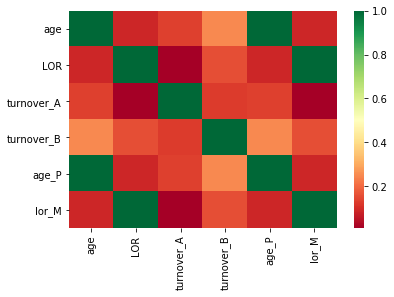

In [44]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='RdYlGn')

As expected, age and age_P are correlated, as well as LOR with lor_M.  We also see a weaker correlation between turnover_B and age (age_P).

## Machine Learning Models

### Overview

There exist many types of models in Machine Learning, each adapted for a particular dataset.  In cases, different models can be used to solve the same problem. In general, the nature of the dataset gives an indication of the appropriate modeling technique.
Generally speaking, machine Learning models can classifed in two categories: supervised and unsupervised learning.
The most common ones in each category are listed below:

* **Supervised Learning**

 * Linear Regression 
 * Logistic Regression
 * Linear/quadratic discriminant analysis
 * Decision trees
 * Random Forest
 * Support vector machine
 * Naive Bayes
 * AdaBoost
 * Gradient-boosting trees
 * Simple neural network


* **Unsupervised Learning**

 * K-means clustering
 * Gaussian mixture model
 * Hierarchical clustering
 * Recommender system

In what follows, we will first use **Random Forest**.  Such models are used for classification or regression and improve the accuracy of a simple decision tree by generating multiple decision trees and taking a majority vote of them to predict the output, which can be a continuous variable for a regression problem or a discrete variable for classifcation.
  
Avantages: 
   - Considered as a highly accurate and robust method because of the number of decision trees
   - It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
   - The algorithm can be used in both classification and regression problems.
   - Random forests can also handle missing values. There are two ways to handle these: using median values to replace continuous variables, and computing the proximity-weighted average of missing values.
   - You can get the relative feature importance, which helps in selecting the most contributing features for the classifier.
   
Disadvantages:
   - Random forests is slow in generating predictions because it has multiple decision trees. Whenever it makes a prediction, all the trees in the forest have to make a prediction for the same given input and then perform voting on it. This whole process is time-consuming.
   - The model is difficult to interpret compared to a decision tree, where you can easily make a decision by following the path in the tree.
 

### Data preparation

The columns type_A, type_B are assumed categorical.  To better analyse them, we can generate dummy variables.  The value 0 will be dropped. We do the same for city and loyalty.

In [45]:
dummy_type_A = pd.get_dummies(data.type_A, prefix='type_A', drop_first=True)
dummy_type_B = pd.get_dummies(data.type_B, prefix='type_B', drop_first=True)
dummy_cities = pd.get_dummies(data.city, prefix='city')
dummy_loyalties = pd.get_dummies(data.loyalty, prefix='loyalty')

In [46]:
data_full = pd.concat([data,dummy_type_A, dummy_type_B, dummy_cities, dummy_loyalties], axis=1)

In [84]:
data_full.head()

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,...,city_197,city_209,city_219,city_229,city_235,loyalty_0,loyalty_1,loyalty_2,loyalty_3,loyalty_99
0,1,99,77,66,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,159,45,2,3,1,3,3,1,...,0,0,0,0,0,0,1,0,0,0
2,1,1,220,42,2,2,1,3,6,1,...,0,0,0,0,0,0,1,0,0,0
3,1,99,303,31,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,99,306,62,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
data_full.columns

Index(['TARGET', 'loyalty', 'ID', 'age', 'city', 'LOR', 'prod_A', 'type_A',
       'type_B', 'prod_B', 'turnover_A', 'turnover_B', 'contract', 'age_P',
       'lor_M', 'type_A_3', 'type_A_6', 'type_B_3', 'type_B_6', 'type_B_9',
       'city_-999999', 'city_0', 'city_1', 'city_2', 'city_3', 'city_4',
       'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11',
       'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_22', 'city_23', 'city_28', 'city_30', 'city_31',
       'city_33', 'city_47', 'city_49', 'city_51', 'city_53', 'city_58',
       'city_72', 'city_73', 'city_84', 'city_89', 'city_94', 'city_104',
       'city_107', 'city_110', 'city_111', 'city_114', 'city_115', 'city_116',
       'city_121', 'city_122', 'city_125', 'city_126', 'city_127', 'city_129',
       'city_131', 'city_137', 'city_141', 'city_142', 'city_148', 'city_161',
       'city_174', 'city_177', 'city_178', 'city_187', 'city_191', 'city_197',
       'cit

### Preparing X,y and splitting training and test data

The full dataset is first considered.

In [61]:
X = data_full[['loyalty', 'age', 'LOR', 'turnover_A', 'turnover_B', 'contract', 'age_P',
       'type_A_3', 'type_A_6', 'type_B_3', 'type_B_6', 'type_B_9', 'prod_A', 'prod_B',
       'city_-999999', 'city_0', 'city_1', 'city_2', 'city_3', 'city_4',
       'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11',
       'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_22', 'city_23', 'city_28', 'city_30', 'city_31',
       'city_33', 'city_47', 'city_49', 'city_51', 'city_53', 'city_58',
       'city_72', 'city_73', 'city_84', 'city_89', 'city_94', 'city_104',
       'city_107', 'city_110', 'city_111', 'city_114', 'city_115', 'city_116',
       'city_121', 'city_122', 'city_125', 'city_126', 'city_127', 'city_129',
       'city_131', 'city_137', 'city_141', 'city_142', 'city_148', 'city_161',
       'city_174', 'city_177', 'city_178', 'city_187', 'city_191', 'city_197',
       'city_209', 'city_219', 'city_229', 'city_235', 'loyalty_0',
       'loyalty_1', 'loyalty_2', 'loyalty_3', 'loyalty_99']]

y = data_full[['TARGET']]

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest

We train the model.

In [51]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(X_test)))

Accuracy: 0.928180737218


Let's classify the features by order of importance.

In [52]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp.head(10)

turnover_A    0.341209
turnover_B    0.295192
age           0.098266
age_P         0.094140
LOR           0.038321
prod_B        0.022156
type_A_3      0.019533
loyalty       0.017943
type_B_3      0.017931
prod_A        0.015239
dtype: float64

Let's train the model using the first 4, 5, 6... features.  By successive trials, we see that the highest accuracy is obtained with 8 features.

In [63]:
X = data_full[feature_imp.head(8).index.values]
y = data_full[['TARGET']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(X_test)))

Accuracy: 0.93079667063


This confirms these selected features capture most of the relevant data.

### Other models (using Pipeline)

One can train other types of modules.  By using Pipeline, it makes easier to combine various steps in the workflow: scaling, adding new features by using PolynomialFeatures, etc.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Edit model step in pipeline
pl = Pipeline([
        #('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)),
        ('rescale', StandardScaler()),
        ('int', PolynomialFeatures(degree=3, interaction_only=True)),
        #('clf_cv', RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=5))
        #('logreg_cv', GridSearchCV(LogisticRegression(), param_grid, cv=10))
        #('clf', LogisticRegression())
        #('ridge', Ridge(normalize=True))
        #('clf', LinearRegression())
        #('clf', OneVsRestClassifier(LogisticRegression()))
        #('knn', KNeighborsClassifier(n_neighbors=3))
        ('clf', RandomForestClassifier(n_estimators=100, criterion='entropy')) # Adjusting parameters
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy: ", accuracy)


Accuracy:  0.930083234245


The best accuracy is obtained with Random Forest Classifier (~0.92).

### Neural network using Keras

NB: Keras will split the data into training/test sets.

In [91]:
# Import necessary modules
import keras
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential, save_model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline

X = data_full[feature_imp.head(8).index.values]
y = data_full[['TARGET']]

# Predictors
predictors = X.as_matrix()

# n_cols
n_cols = predictors.shape[1]

# Convert the target to categorical: target
target = to_categorical(y)

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=5)

def model():
    
    # Set up the model
    model = Sequential()

    # Neural network architecture
    model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))

    # Add the output layer
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # other optimizer: rmsprop
    
    return model

pl = Pipeline([
        #('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)),
        ('rescale', StandardScaler()),
        ('kc', KerasClassifier(build_fn=model, epochs=10, validation_split=0.3, verbose=True))
    ])

# Fit the model
pl.fit(predictors, target)

Train on 9811 samples, validate on 4205 samples
Epoch 1/10
9811/9811 [==============================] - 1s 77us/step - loss: 0.4266 - acc: 0.8024 - val_loss: 0.5664 - val_acc: 0.7127
Epoch 2/10
9811/9811 [==============================] - 1s 79us/step - loss: 0.3813 - acc: 0.8267 - val_loss: 0.5911 - val_acc: 0.7177
Epoch 3/10
9811/9811 [==============================] - 1s 107us/step - loss: 0.3693 - acc: 0.8340 - val_loss: 0.5604 - val_acc: 0.7455
Epoch 4/10
9811/9811 [==============================] - 1s 138us/step - loss: 0.3589 - acc: 0.8446 - val_loss: 0.6335 - val_acc: 0.7008
Epoch 5/10
9811/9811 [==============================] - 2s 246us/step - loss: 0.3426 - acc: 0.8496 - val_loss: 0.4277 - val_acc: 0.7498
Epoch 6/10
9811/9811 [==============================] - 1s 145us/step - loss: 0.3354 - acc: 0.8524 - val_loss: 0.5121 - val_acc: 0.7027
Epoch 7/10
9811/9811 [==============================] - 2s 156us/step - loss: 0.3150 - acc: 0.8690 - val_loss: 0.4018 - val_acc: 0.7703
Ep

Pipeline(memory=None,
     steps=[('rescale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kc', <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002156F1E54A8>)])